### Main imports and GPU settings

In [98]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch import Tensor
import matplotlib.pyplot as plt


# Show all available GPUs
print(torch.cuda.get_device_name(0))

# Set device to GPU if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

print('=======================\n')
GPU = False
# Set default tensor type to cuda.FloatTensor if GPU is available
if torch.cuda.is_available() and GPU:
    torch.set_default_tensor_type(torch.cuda.FloatTensor)
    torch.set_default_device(device)
    torch.set_default_dtype(torch.float32)
    print(f"Using GPU: {torch.cuda.get_device_name(0)}")
    print(f"Dtype: {torch.get_default_dtype()}")
    print(f"Device: {torch.cuda.current_device()}")
else:
    torch.set_default_tensor_type(torch.FloatTensor)
    device = torch.device("cpu")
    torch.set_default_device(device)
    print("Using CPU")


# Set seed for reproducibility
torch.manual_seed(0)

torch.autograd.set_detect_anomaly(True)

NVIDIA GeForce RTX 2060
cuda:0

Using CPU


### Local imports of classes

In [99]:
from tqdm.notebook import tqdm
import random
import importlib


# Local imports modules
import classes.Systems as Systems
import classes.PID as PID

# Reload modules
importlib.reload(Systems)
importlib.reload(PID)

# Local import reloaded classes
from classes.Systems import Trolley
from classes.PID import PID

Build Neural Network

In [100]:
# Defining the architecture of the neural network
class PIDNN(nn.Module):
    def __init__(self):
        super(PIDNN, self).__init__()
        self.fc1 = nn.Linear(3, 10)
        self.fc2 = nn.Linear(10, 3)

        # Activation functions
        self.act_tahn = nn.Tanh()
        self.act_relu = nn.ReLU()

        # Initialize weights
        nn.init.kaiming_uniform_(self.fc1.weight, nonlinearity='relu', mode='fan_in')
        nn.init.kaiming_uniform_(self.fc2.weight, nonlinearity='relu', mode='fan_in')

        # Initialize biases
        self.fc1.bias.data.fill_(0.1)
        # self.fc2.bias.data.fill_(0.1)

    def forward(self, x) -> Tensor:
        # x = self.norm(x, dim=0, p=2)
        x = self.fc1(x)
        x = self.act_relu(x)
        x = self.fc2(x) 
        return x
    

# Custom Loss Function
class CustomLoss(nn.Module):
    def __init__(self):
        super(CustomLoss, self).__init__()

    def forward(self, W: Tensor, Y: Tensor, Kp: Tensor, Ki: Tensor, Kd: Tensor) -> Tensor:
        """
        Args:
            vector_K (tensor): [Kp_t, Kp_t_1, Ki_t, Ki_t_1, Kd_t, Kd_t_1] vector of the gains
            vector_E (tensor): [E_t, E_t_1] vector of the errors
            dt (float): time step between the current and previous position

        Returns:
            loss (tensor): loss function
        """
        # Smooth mean absolute error
        loss = torch.mean(torch.sqrt(torch.pow(W - Y, 2) + 1e-6))
        penalty = torch.relu(Kp) + torch.relu(Ki) + torch.relu(Kd)
    
        return loss + penalty


### Creating the model, loss function and optimizer

In [101]:
# Model
pidnn = PIDNN()

# Loss function
custom_loss = CustomLoss()

# Optimizers
optimizer = optim.Adam(pidnn.parameters(), lr=0.0001)
# optimizer = optim.SGD(pidnn.parameters(), lr=0.001, momentum=0.9)

Init params

In [102]:
# Simulation
DT = torch.tensor(0.02)
TIME = torch.arange(0, 120, DT)
TARGET = 6. * torch.ones(len(TIME))
DISTURBANCE = torch.zeros(len(TIME))

# System
mass = torch.tensor(2.)
friction = torch.tensor(0.5)
trolley = Trolley(mass=mass, friction=friction, dt=DT)
trolley.spring_constant = torch.tensor(1.)
trolley.spring_natural_length = torch.tensor(5.)

# PID
Kp = torch.tensor(1.)
Ki = torch.tensor(0.1)
Kd = torch.tensor(0.5)
pid = PID(Kp, Ki, Kd)

# U_min = torch.tensor(-400.)
# # U_max = torch.tensor(400.)
# pid.setLims(U_min, U_max)

In [103]:
# Loss
feedback_Loss = torch.zeros(len(TIME))

# Gains
feedback_Kp = torch.zeros(len(TIME))
feedback_Ki = torch.zeros(len(TIME))
feedback_Kd = torch.zeros(len(TIME))

# System
feedback_x = torch.zeros(len(TIME))
feedback_u = torch.zeros(len(TIME))

In [104]:
EPOCHS = 5
# Epochs loop
for epoch in range(EPOCHS):
    
    TARGET[TIME>40] = random.uniform(0, 15)
    TARGET[TIME>80] = random.uniform(0, 15)
    TARGET[TIME>100] = random.uniform(0, 15)

    # Time loop
    with tqdm(total=len(TIME)-1) as pbar:
        control_output = torch.tensor(0.)
        for idx in range(1, len(TIME)):
            
            target = TARGET[idx]
            disturbance = DISTURBANCE[idx]
            position = trolley.get_position()

            #------------- PREDICTION -------------#
            # Predict the gains: Kp, Ki, Kd
            prediction = pidnn(torch.tensor([target, position, control_output]))
            Kp, Ki, Kd = prediction

            # Set the gains
            with torch.no_grad():
                pid.Kp.copy_(Kp)
                pid.Ki.copy_(Ki)
                pid.Kd.copy_(Kd)

            # Compute the control output
            control_output = pid.compute(position, target, DT)

            #------------- SYSTEM -------------#
            # Compute the new position
            trolley.apply_control(control_output, disturbance)
            # Compute the error
            new_position = trolley.get_position()
            error = target - new_position
            # error.requires_grad = True

            #------------- TRAINING -------------#
            # Compute the loss
            target.requires_grad = True
            Kp_ = Kp.detach().clone().requires_grad_(True)
            Ki_ = Ki.detach().clone().requires_grad_(True)
            Kd_ = Kd.detach().clone().requires_grad_(True)
            loss = custom_loss(target, new_position, Kp_, Ki_, Kd_)

            loss.backward(retain_graph=True)
            optimizer.step()
            optimizer.zero_grad()

            # Update the progress bar
            pbar.update(1)
            pbar.set_description(f"Epoch {epoch+1}/{EPOCHS} | Loss: {loss.item():.4f}")
            pbar.set_postfix({"Kp": Kp.item(), "Ki": Ki.item(), "Kd": Kd.item()})
        

            #------------- FEEDBACK -------------#
            # Loss
            feedback_Loss[idx] = loss.item()
            
            # Gains
            feedback_Kp[idx] = Kp.item()
            feedback_Ki[idx] = Ki.item()
            feedback_Kd[idx] = Kd.item()

            # System
            feedback_x[idx] = new_position.item()
            feedback_u[idx] = control_output.item()     

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
# Show weights
pidnn.fc1.weight    

Parameter containing:
tensor([[ 1.1717,  1.2307,  1.2478],
        [ 0.2814, -1.2298,  0.1301],
        [-0.8847, -1.3180,  1.2565],
        [ 1.0753, -1.4107,  0.2647],
        [-0.2382, -0.2327, -0.6474],
        [ 0.5438, -0.8376,  0.5184],
        [ 0.7152,  1.0124,  0.5288],
        [-1.3997, -0.9174,  0.7061],
        [ 0.2960, -1.1032, -0.8143],
        [ 1.3304,  0.9529, -0.6166]], requires_grad=True)

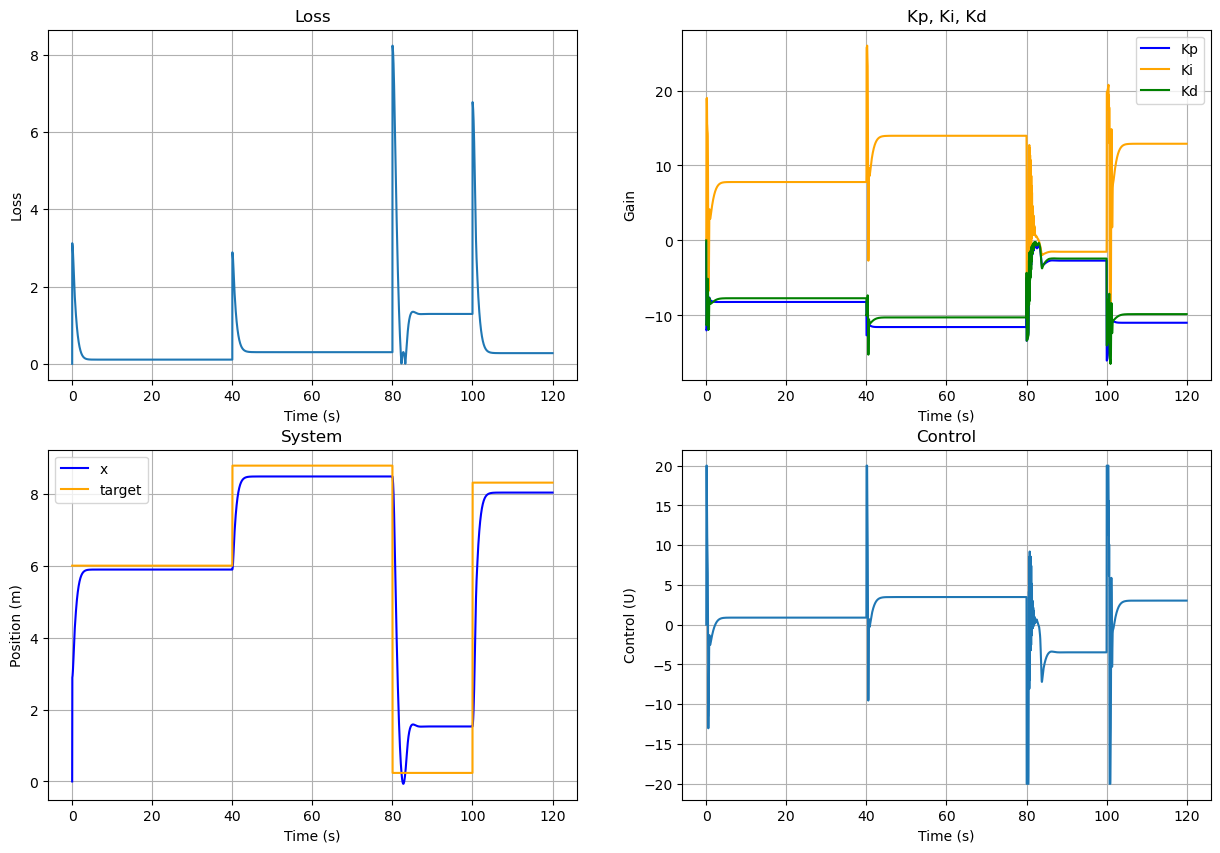

In [ ]:
def plot_results():
    fig, axs = plt.subplots(2, 2, figsize=(15, 10))
    
    # Loss
    axs[0, 0].plot(TIME, feedback_Loss)
    axs[0, 0].set_title("Loss")
    axs[0, 0].set_xlabel("Time (s)")
    axs[0, 0].set_ylabel("Loss")
    
    # Gains
    axs[0, 1].plot(TIME, feedback_Kp, label="Kp", color="blue")
    axs[0, 1].plot(TIME, feedback_Ki, label="Ki", color="orange")
    axs[0, 1].plot(TIME, feedback_Kd, label="Kd", color="green")
    axs[0, 1].set_title("Kp, Ki, Kd")
    axs[0, 1].set_xlabel("Time (s)")
    axs[0, 1].set_ylabel("Gain")
    axs[0, 1].legend()

    # System
    axs[1, 0].plot(TIME, feedback_x, label="x", color="blue")
    axs[1, 0].plot(TIME, TARGET, label="target", color="orange")
    axs[1, 0].set_title("System")
    axs[1, 0].set_xlabel("Time (s)")
    axs[1, 0].set_ylabel("Position (m)")
    axs[1, 0].legend()

    # Control
    axs[1, 1].plot(TIME, feedback_u)
    axs[1, 1].set_title("Control")
    axs[1, 1].set_xlabel("Time (s)")
    axs[1, 1].set_ylabel("Control (U)")

    # Grid
    for ax in axs.flat:
        ax.grid(True)

    plt.show()

plot_results()

In [ ]:
# Save the model
torch.save(pidnn.state_dict(), 'model.pth')
print("Model saved successfully")       

Model saved successfully
